In [1]:
import numpy as np
import cv2 # OpenCV
import matplotlib
import matplotlib.pyplot as plt
import math
import collections

In [2]:
# iscrtavanje slika u notebook-u
%matplotlib inline
# prikaz vecih slika
matplotlib.rcParams['figure.figsize'] = 16,12

In [3]:
# keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD

Using TensorFlow backend.


In [4]:
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

def image_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def image_bin(image_gs):
    height, width = image_gs.shape[0:2]
    image_binary = np.ndarray((height, width), dtype=np.uint8)
    ret, image_bin = cv2.threshold(image_gs, 127, 255, cv2.THRESH_BINARY)
    return image_bin

def invert(image):
    return 255-image

def display_image(image, color=False):
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')

def dilate(image):
    kernel = np.ones((3, 3)) # strukturni element 3x3 blok
    return cv2.dilate(image, kernel, iterations=1)

def erode(image):
    kernel = np.ones((3, 3)) # strukturni element 3x3 blok
    return cv2.erode(image, kernel, iterations=1)

In [5]:
def resize_region(region):
    return cv2.resize(region, (28, 28), interpolation=cv2.INTER_NEAREST)

In [6]:
def select_roi(image_orig, image_bin):
    contours, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    sorted_regions = [] # lista sortiranih regiona po X osi
    regions_array = []
    print(len(contours))
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour) # koordinate i velicina granicnog pravougaonika
        area = cv2.contourArea(contour)
        if area > 100 and h < 100 and h > 15 and w > 20:
            # kopirati [y:y+h+1, x:x+w+1] sa binarne slike i smestiti u novu sliku
            # oznaciti region pravougaonikom na originalnoj slici sa rectangle funkcijom
            region = image_bin[y:y+h+1, x:x+w+1]
            regions_array.append([resize_region(region), (x, y, w, h)])
            cv2.rectangle(image_orig, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    regions_array = sorted(regions_array, key=lambda x: x[1][0])
    sorted_regions = [region[0] for region in regions_array]
    return image_orig, sorted_regions

In [7]:
def scale_to_range(image):
    return image/255

In [8]:
def matrix_to_vector(image):
    return image.flatten()

In [9]:
def prepare_for_ann(regions):
    ready_for_ann = []
    for region in regions:
        scale = scale_to_range(region)
        ready_for_ann.append(matrix_to_vector(scale))
    return ready_for_ann

In [10]:
def convert_output(alphabet):
    nn_outputs = []
    for index in range(len(alphabet)):
        output = np.zeros(len(alphabet))
        output[index] = 1
        nn_outputs.append(output)
    return np.array(nn_outputs)

In [11]:
def create_ann(output_size):
    ann = Sequential()
    ann.add(Dense(128, input_dim=784, activation='sigmoid'))
    ann.add(Dense(output_size, activation='sigmoid'))
    return ann

In [12]:
def train_ann(ann, X_train, y_train, epochs):
    X_train = np.array(X_train, np.float32) # dati ulaz
    y_train = np.array(y_train, np.float32) # zeljeni izlazi na date ulaze
    
    print("\nTraining started...")
    sgd = SGD(lr=0.01, momentum=0.9)
    ann.compile(loss='mean_squared_error', optimizer=sgd)
    ann.fit(X_train, y_train, epochs=epochs, batch_size=1, verbose=0, shuffle=False)
    print("\nTraining completed...")
    return ann

In [13]:
def winner(output):
    return max(enumerate(output), key=lambda x: x[1])[0]

In [14]:
def display_result(outputs, alphabet):
    result = []
    for output in outputs:
        result.append(alphabet[winner(output)])
    return result

17


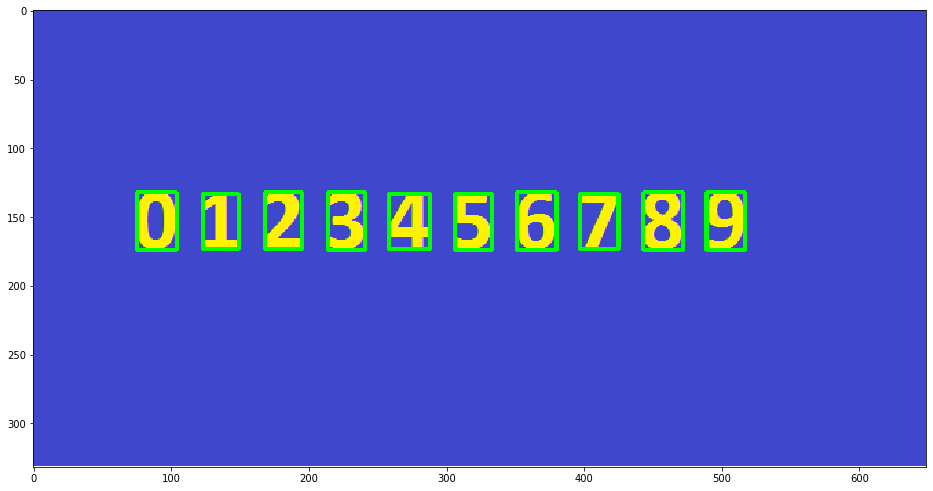

In [15]:
#obucavanje
#priprema slike sa brojevima
image_color = load_image('images/brojevi.png')
img = image_bin(image_gray(image_color))
img_bin = erode(dilate(img))
selected_regions, numbers = select_roi(image_color.copy(), img_bin)
display_image(selected_regions)

In [16]:
#treniranje
alphabet = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

inputs = prepare_for_ann(numbers)
outputs = convert_output(alphabet)
ann = create_ann(output_size=10)
ann = train_ann(ann, inputs, outputs, epochs=2000)


Training started...

Training completed...


In [17]:
result = ann.predict(np.array(inputs[2:4], np.float32))
print(result)
print("\n")
print(display_result(result, alphabet))

[[0.01286769 0.02165759 0.9617627  0.02068943 0.00797939 0.00128746
  0.00328192 0.02064076 0.01952174 0.0048801 ]
 [0.00496572 0.01233429 0.01870781 0.9596596  0.01384255 0.01905379
  0.00261966 0.00972939 0.01670044 0.01984842]]


[2, 3]


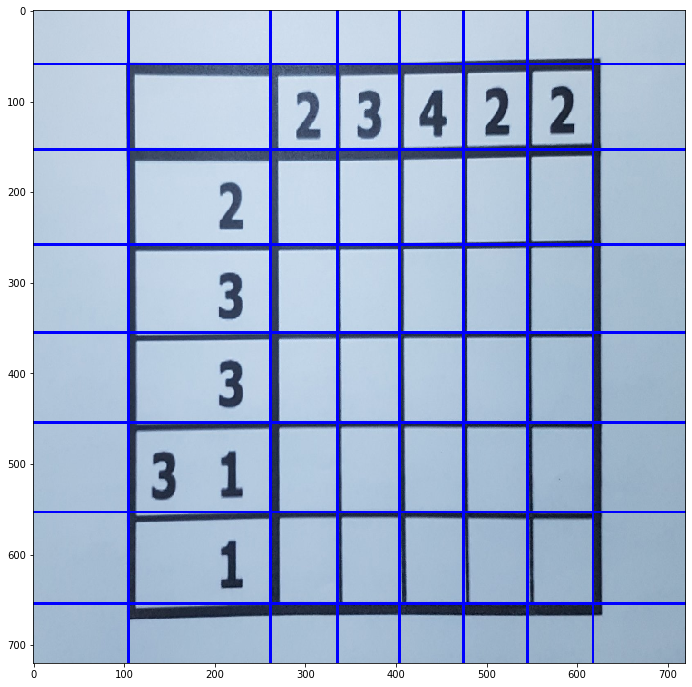

In [20]:
img = cv2.imread('images/nonogram14.jpg')# ucitavanje slike sa diska
img = cv2.resize(img, (720,720)) 
slikica = img.copy()
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # konvertovanje iz BGR u RGB model boja (OpenCV ucita sliku kao BGR)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
slikica2 = image_bin(gray.copy())
slikicaa = erode(dilate(slikica2))
edges = cv2.Canny(gray,90,150,apertureSize = 3)
#kernel = np.ones((3,3),np.uint8)
#edges = cv2.dilate(edges,kernel,iterations = 1)
#kernel = np.ones((5,5),np.uint8)
#edges = cv2.erode(edges,kernel,iterations = 1)
lines = cv2.HoughLines(edges, 1,np.pi/180, 150)
vert_linije=[]
horiz_linije=[]
for line in lines:
    rho,theta=line[0]
    if(np.sin(theta)==1):
        horiz_linije.append(line)
    elif(np.sin(theta)==0):
        vert_linije.append(line)
filtrirane_linije=[]
posljednji_rho=None
vert_linije.sort(key=lambda element: element[0][0])
for line in vert_linije:
    rho,theta=line[0]
    if posljednji_rho==None:
        filtrirane_linije.append(line)
        posljednji_rho=rho
    else:
        if (rho-posljednji_rho>20):
            posljednji_rho=rho
            filtrirane_linije.append(line)
posljednji_rho=None
horiz_linije.sort(key=lambda element: element[0][0])
for line in horiz_linije:
    rho,theta=line[0]
    if posljednji_rho==None:
        posljednji_rho=rho
        filtrirane_linije.append(line)
    else:
        if (rho-posljednji_rho>20):
            posljednji_rho=rho
            filtrirane_linije.append(line)
for line in filtrirane_linije:
    rho,theta=line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)
plt.imshow(img)

In [21]:
import math

50


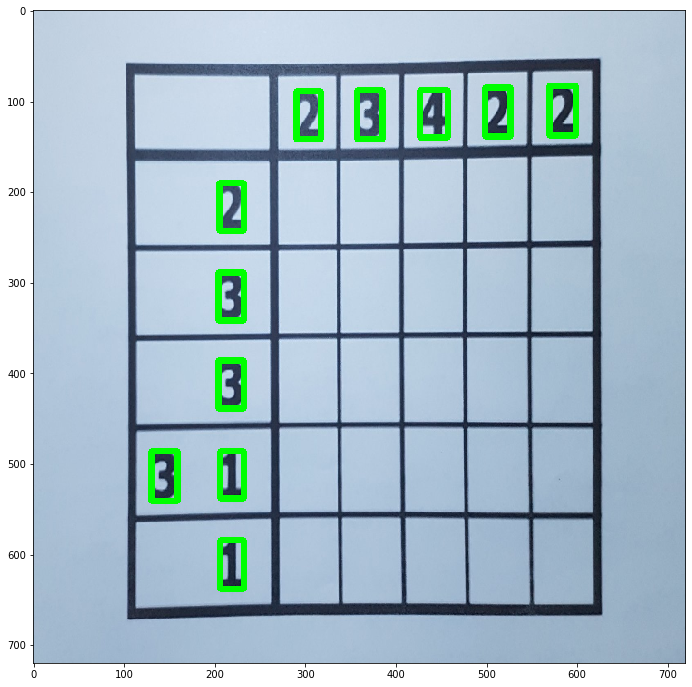

In [28]:
def select_one_region(image_orig, image_bin):
    contours, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    print(len(contours))
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        area = cv2.contourArea(contour)
        if h < 90 and h > 40 and w > 20 and w<50:
            region = image_bin[y:y+h+1, x:x+w+1]
            cv2.rectangle(image_orig, (x, y), (x + w, y + h), (0, 255, 0), 5)
    return image_orig, region
baha, aha = select_one_region(slikica.copy(),slikicaa)
display_image(baha)

ROWS PRAVOUGAONICI
U rows pravougaonicima se moze nalaziti brojeva:2
2
2
3
4
4
COLUMNS PRAVOUGAONICI
U columns pravougaonicima se moze nalaziti brojeva:0
2


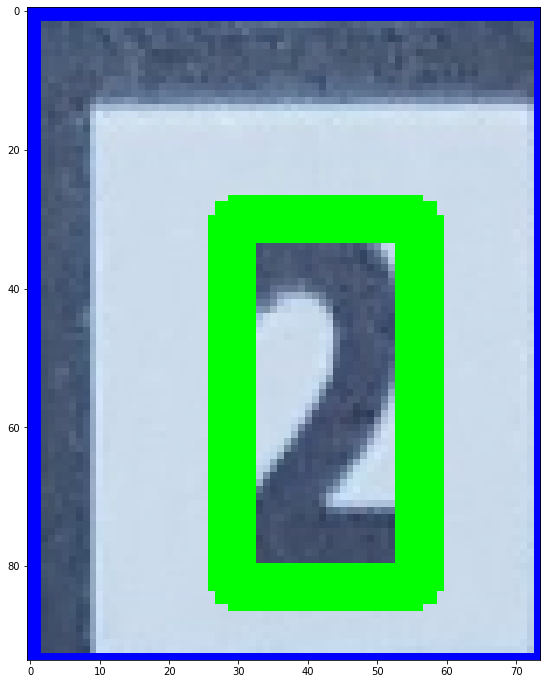

2


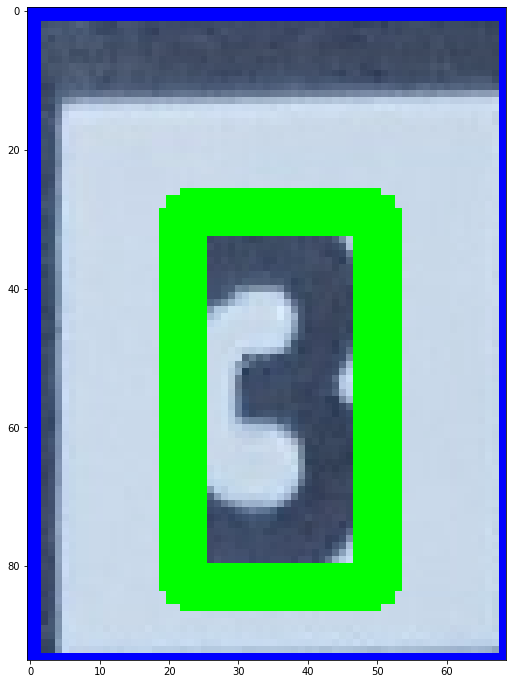

3


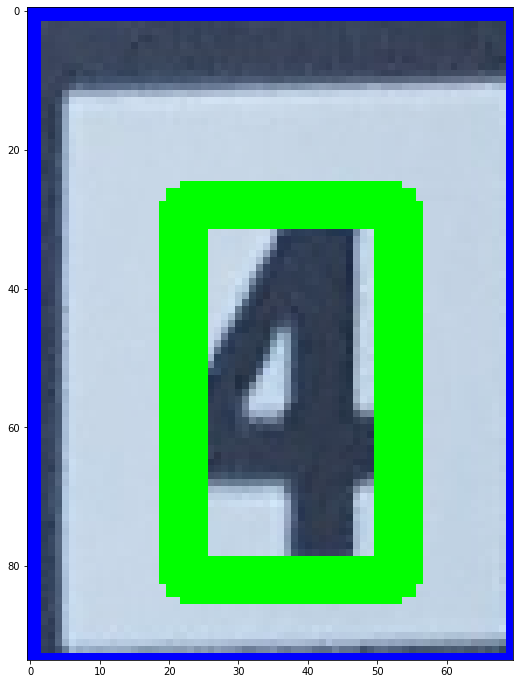

2


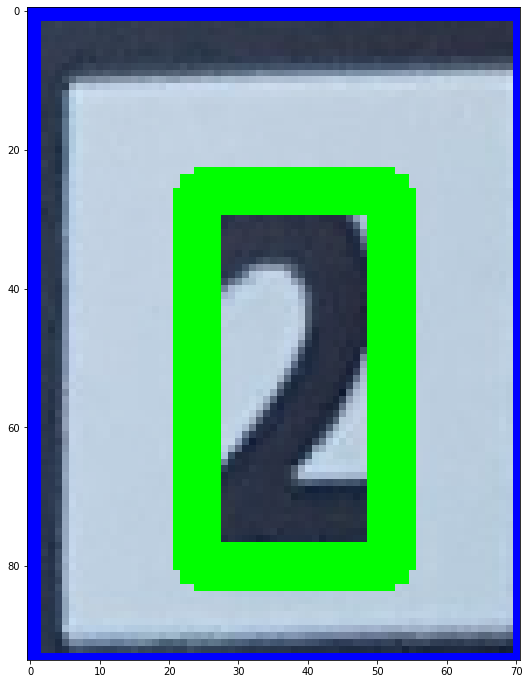

2


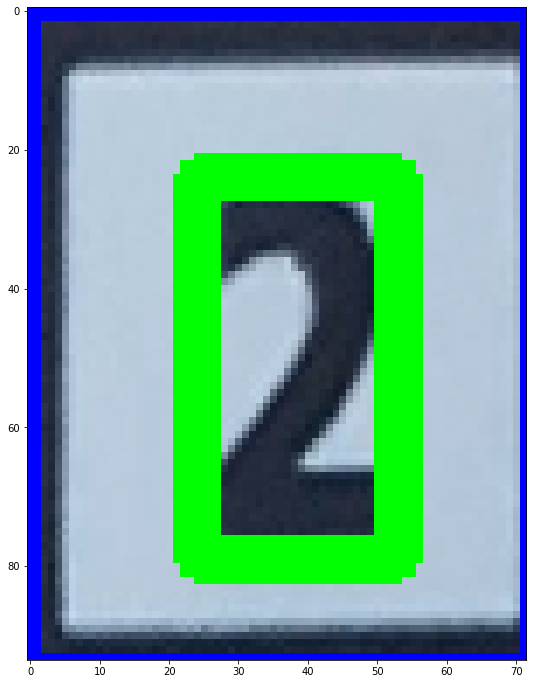

In [29]:
intersections=[]
p=1
for i in range(len(filtrirane_linije)):
    rho1, theta1 = filtrirane_linije[i][0]
    for ii in range(p,len(filtrirane_linije)):
        rho2, theta2 = filtrirane_linije[ii][0]
        if((np.sin(theta1)==1 and np.sin(theta2)==0) or (np.sin(theta1)==0 and np.sin(theta2)==1)):
            A = np.array([
                [np.cos(theta1), np.sin(theta1)],
                [np.cos(theta2), np.sin(theta2)]
            ])
            b = np.array([[rho1], [rho2]])
            tacka = np.linalg.solve(A, b)
            intersections.append(tacka)
    p=p+1
    if(p==len(filtrirane_linije)):
        break
korjen=math.sqrt(len(intersections))
korjen=int(korjen)
pravougaonici=[]
br=0
bra=1
for i in range((korjen-1)**2):
        if(br!=0 and bra==korjen):
            bra=1
            br=br+1
        pravougaonici.append([intersections[br],intersections[br+korjen],intersections[br+1],intersections[br+korjen+1]])
        br=br+1
        bra=bra+1
zadnji_pravougaonik=pravougaonici[-1]#iskoristicemo ga za mjeru koliko brojeva moze stati u pravougaonike
rows_pravougaonici=[]
columns_pravougaonici=[]
rows_regions_array=[]
columns_regions_array=[]
brojac=0
for i in pravougaonici:
    if (brojac>0 and brojac<(korjen-1)):
        rows_pravougaonici.append(i)
    if(brojac%(korjen-1)==0 and brojac>0):
        columns_pravougaonici.append(i)
    brojac=brojac+1
print("ROWS PRAVOUGAONICI")
rows_br=int((rows_pravougaonici[0][1][0]-rows_pravougaonici[0][0][0])/(zadnji_pravougaonik[1][0]-zadnji_pravougaonik[0][0]))
print("U rows pravougaonicima se moze nalaziti brojeva:"+str(rows_br))
for i in rows_pravougaonici:
    image=img[int(i[0][1]):int(i[2][1]), int(i[0][0]):int(i[1][0])]
    slika = image_bin(image_gray(image))
    #plt.imshow(image)
    slika_bin=erode(dilate(slika))
    selektovani_region, broj = select_one_region(image.copy(), slika_bin)
    resize_broj = resize_region(broj)
    rows_regions_array.append(resize_broj);
    #plt.imshow(image)
    #plt.pause(1)
print("COLUMNS PRAVOUGAONICI")
columns_br=int((columns_pravougaonici[0][2][1]-columns_pravougaonici[0][0][1])/(zadnji_pravougaonik[2][1]-zadnji_pravougaonik[0][1]))
print("U columns pravougaonicima se moze nalaziti brojeva:"+str(columns_br))
for i in columns_pravougaonici:
    image=img[int(i[0][1]):int(i[2][1]), int(i[0][0]):int(i[1][0])]
    #image=slikica.copy()
    slika = image_bin(image_gray(image))
    slika_bin=erode(dilate(slika))
    #plt.imshow(image)
    selektovani_region, broj = select_one_region(image.copy(), slika_bin)
    display_image(selektovani_region)
    #resize_broj = resize_region(broj)
    #columns_regions_array.append(resize_broj);
    #plt.imshow(resize_broj)
    #plt.imshow(image)
    plt.pause(1)
    

In [30]:
test_inputs =  prepare_for_ann(columns_regions_array)
result = ann.predict(np.array(test_inputs, np.float32))

ValueError: Error when checking input: expected dense_1_input to have shape (784,) but got array with shape (1,)

In [ ]:
print(display_result(result, alphabet))

In [ ]:
print(result)